This notebook is a walkthrough of interpreting  DNABERT-reg model using attribution by integrated gradient. Attribution measures the relative importance of each nucleotide to the predicted output. The methodology is explained in https://arxiv.org/pdf/1703.01365.pdf. 

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 46.6 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 56.0 MB/s 
     |████████████████████████████████| 6.6 MB 36.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install captum

     |████████████████████████████████| 1.4 MB 5.2 MB/s 


In [ ]:
!pip install Bio

     |████████████████████████████████| 269 kB 5.2 MB/s 
     |████████████████████████████████| 2.3 MB 60.8 MB/s 


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig,AdamW , get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sb
from scipy.stats.stats import pearsonr
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance, LayerIntegratedGradients

In [ ]:
random.seed(42)

In [ ]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

Using GPU.


In [ ]:
def seq2kmer(seq, k = 4):
    """
    Function provided by Ji et al. (https://github.com/jerryji1993/DNABERT)
    Will convert given sequence into kmer.
    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    #kmers = " ".join(kmer)
    return kmer

In [ ]:
def kmer2seq(kmers):
    """
    Convert kmers to original sequence
    
    Arguments:
    kmers -- str, kmers separated by space.
    
    Returns:
    seq -- str, original sequence.
    """
    kmers_list = kmers.split(" ")
    bases = [kmer[0] for kmer in kmers_list[0:-1]]
    bases.append(kmers_list[-1])
    seq = "".join(bases)
    assert len(seq) == len(kmers_list) + len(kmers_list[0]) - 1
    return seq

In [ ]:
def tokenize(seq_kmers, labels):
  """
  package ground truth labels, kmer representation of sequence into dataset that
  is suitable to pass through model

  Argument:
  seq_kmers: kmer representation of local promoter sequence
  labels: ground truth gene expression of respective local promoter sequence

  Returns:
  dataset:tensor object that package respective local promoter sequence's 
          tokenized representation, ground truth gene expression, attention mask
  """
  input_ids = []
  attention_masks = []

  for sent in seq_kmers:
      encoded_dict = DNABERT_Tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          pad_to_max_length = False,
                          return_attention_mask = True,   # Construct attention masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      #since all sequence are same length, it will simply be all 1
      attention_masks.append(encoded_dict['attention_mask'])


  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)
  return dataset

In [ ]:
def attention_landscapes(attention_scores):
    attention_scores_mean = attention_scores.mean(axis=0)
    attention_scores_mean_log = np.log(attention_scores_mean)
    start = 50 - len(attention_scores_mean_log)
    df_attention_scores_mean_log = pd.DataFrame(data=attention_scores_mean_log, index = range(start, 50))
    plt.plot(df_attention_scores_mean_log)
    plt.title("mean attention score per nucleotide position")
    plt.ylabel("mean attention score (log2)")
    plt.xlabel("relative position to TTS")
    plt.show()

In [ ]:
def heatmapallhead(attention_scores):
    fig, ax = plt.subplots(figsize=(20, 9))
    start = 50 - len(attention_scores[0])
    df_attention_scores = pd.DataFrame(data = attention_scores, index = range(len(attention_scores)), columns = range(start, 50))
    sb.heatmap(df_attention_scores)
    plt.title("attention map: summary heads")
    plt.ylabel("sequence")
    plt.xlabel("relative position to TTS")
    plt.show()

In [ ]:
def heatmapeachhead():
    plt.figure(figsize=(20, 100))
    plt.subplots_adjust(hspace=0.5)
    for i in range(0, 12):
        filename = "att_" + str(i + 1)
        file = np.load(filename + ".npy")
        ax = plt.subplot(12, 1, i + 1)
        df_attention_score = pd.DataFrame(data = file, index = range(len(attention_scores)), columns = range(-250, 50))
        sb.heatmap(df_attention_score)
        
        ax.set_title(filename + " : attention_score heatmap")
        
        ax.set_ylabel("sequence")
        ax.set_xlabel("relative position to TTS")



In [ ]:
def decode(tokenized_seqs):
    """
    convert tokenized representation of local promoter sequences back to its nucleotide
    format

    Arguments:
    tokenized_seqs: tokenized representation of local promoter sequence, list

    Returns:
    seqs: local promoter sequences represented as ATCG, numpy array
    """
    seqs = None
    for tokenized_seq in tokenized_seqs:
        seq = DNABERT_Tokenizer.decode(tokenized_seq,
                                        skip_special_tokens = True
                                        )
        seq = kmer2seq(seq)
        
        if seqs is None:
            seqs = seq
        else:
            seqs = np.hstack((seqs, seq))
    return seqs

In [ ]:
def measurement_metric(predictions, true_labels, measurement):
    metric = measurement(true_labels, predictions)               
    return metric

Import input that was parsed using inputparser.ipynb

In [ ]:
final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF910TAZ/hg38_msxTm_ENCFF910TAZ.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF292FVY/hg38_msxTm_ENCFF292FVY.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF597FGD/hg38_msxTm_ENCFF597FGD.csv")
#final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF279XTY/hg38_msxTm_ENCFF279XTY.csv")

Extract the local promoter sequences and divide into train, test, validation split

In [ ]:
seqs = final_matrix["Sequence"] #original length
train_seqs, test_seqs = train_test_split(seqs, test_size=0.2, random_state=1)
train_seqs, val_seqs = train_test_split(train_seqs, test_size=0.25, random_state=1)

In [ ]:
cd /content/drive/MyDrive/master_thesis/models/4-new-12w-0/hg38_msxTm_ENCFF910TAZ/ft_dnabert_model_4mer_save/

/content/drive/MyDrive/master_thesis/models/4-new-12w-0/hg38_msxTm_ENCFF910TAZ/ft_dnabert_model_4mer_save


In [ ]:
DNABERT_Tokenizer = BertTokenizer(vocab_file = "vocab.txt", config = "tokenizer_config.json")

ft_model_config_path = "./config.json"
ft_model_config =BertConfig.from_pretrained(ft_model_config_path, num_labels = 1, attention_probs_dropout_prob = 0.3)

ft_model_weight_path = "./pytorch_model.bin"
ft_dnabert_model_saved = BertForSequenceClassification.from_pretrained(ft_model_weight_path, config = ft_model_config)

In [ ]:
import copy
ft_dnabert_model = copy.deepcopy(ft_dnabert_model_saved)
ft_dnabert_model.to(device)
ft_dnabert_model.eval()
ft_dnabert_model.zero_grad()

In [ ]:
def predict_logits(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    """
    predict logits of the input tokenized local promoter sequence to fine-tuned DNABERT-reg model

    Arguments:
    inputs: tokenized local promoter sequence, pytorch tensors

    output.logits = predicted gene expression level output, int
    """
    inputs = inputs.to(device)
    output = ft_dnabert_model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask)
    return output.logits

In [ ]:
def construct_input_ref_pair(tokenizer, text):
    """
    convert DNA sequence to input_ids, and create corresponding baseline token ids

    Arguements:
    text: DNA sequences, string

    return:
    input_ids: tokenized DNA sequences, pytorch tensor
    ref_input_ids: baseline token ids that act as reference, same length as input_
                    ids, pytorch tensor
    """
    ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
    sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
    cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

    text_len = len(text)
    input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors = 'pt')

    # construct reference token ids 
    ref_text = [ref_token_id] * text_len
    ref_input_ids = tokenizer.encode(ref_text, add_special_tokens=True, return_tensors = 'pt')
    return input_ids, ref_input_ids


def construct_whole_bert_embeddings(model, input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    """
    construct input embedding and ref_input_embedding

    Arguments:
    input_ids: tokenized DNA sequences, pytorch tensor
    ref_input_ids: baseline token ids that act as reference, same length as input_
                    ids, pytorch tensor
    
    Returns:
    input_embeddings: input for DNABERT-reg derived from local promoter sequence
    ref_input_embeddings: baseline input for DNABERT-reg 
    """
    input_ids = input_ids.to(device)
    ref_input_ids = ref_input_ids.to(device)
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

LayerIntegratedGradients and compute the attributions with respect to BertEmbedding

In [ ]:
def summarize_attributions(attributions):
    """
    Summarize attribution
    """
    #sum the last dimension and remove dimension
    attributions = attributions.sum(dim=-1).squeeze(0)
    #normalize attribution
    attributions = attributions / torch.norm(attributions)
    return attributions

In [ ]:
def attribution_kmer_to_nucleotide(attributions_sum, kmer = 4):
    """
    convert attribution of each kmer to attribution to each nucleotide

    Arguments:
    attributions_sum: 1d vector of [tokenized sequence length], numpy array
    real_scores: 1d vector of [sequence length], numpy array
    """
    #exclude the [CLS] and [SEP] tokens
    attr_score = attributions_sum.tolist()[1:-1]

    counts = np.zeros([len(attr_score)+kmer-1])
    real_scores = np.zeros([len(attr_score)+kmer-1])
    for i, score in enumerate(attr_score):
        for j in range(kmer):
            counts[i+j] += 1.0
            real_scores[i+j] += score
    real_scores = real_scores / counts
    return real_scores

In [ ]:
def attribution_wrapper(lig, seq_dataset, kmer = 4):
    """
    wrapper for computing the attribution score for local promoter sequences

    Arguments:
    lig:
    seq_dataset: local promoter sequences of the same length in ATCG format, str/list
    kmer: designated kmer-size that correspond with the finetuned DNABERT-reg model

    Returns:
    real_scores_array: attribution score of [samples length, sequence length], numpy array
    real_scores: attribution score of [sequence length], numpy array
    logits: predicted gene expression level for the input sequence
    """
    #when seq_dataset is a list of sequences
    if isinstance(seq_dataset, list):
        real_scores_array = np.zeros((len(seq_dataset), len(seq_dataset[0])))
        for index, seq in enumerate(seq_dataset):
            input_ids, ref_input_ids = construct_input_ref_pair(DNABERT_Tokenizer, seq2kmer(seq))
            attributions, delta = lig.attribute(inputs=input_ids,
                                          baselines=ref_input_ids,
                                          return_convergence_delta=True)
            attributions_sum = summarize_attributions(attributions).detach().cpu().numpy()

            real_scores = attribution_kmer_to_nucleotide(attributions_sum)
            real_scores_array[index] = real_scores

        return real_scores_array
    #when seq_dataset is a string of sequence
    else:
        seq = seq_dataset
        seq = seq2kmer(seq)
        input_ids, ref_input_ids = construct_input_ref_pair(DNABERT_Tokenizer, seq)
        logits = predict_logits(input_ids)
        attributions, delta = lig.attribute(inputs=input_ids,
                                      baselines=ref_input_ids,
                                      return_convergence_delta=True)
        attributions_sum = summarize_attributions(attributions).detach().cpu().numpy()
        attn_score = attributions_sum.tolist()[1:-1]

        real_scores = attribution_kmer_to_nucleotide(attributions_sum)

        return real_scores, logits


Analysis of attribution scores peak as an indicator of transcription factor type

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

def extracthighattributionmotif(attribution_array, sequences, window_size):
    """
    extract highly attributed motifs from attribution scores and their directionality

    Arguments:
    attribution_array: attribution scores of local promoter sequences, numpy array
    sequences: local promoter sequences correpsond to the attribution_array order, list
    window_size: size of contiguous region of attribution peaks

    Returns:
    df: 
    """
    motif_list = []
    pos_list = []
    attri_list = []
    df = pd.DataFrame()
    for attribution, seq in zip(attribution_array, sequences):
        motifs = []
        pos = []
        attri_type = []
        
        attribution = [0 if -0.1 < x < 0.1 else x for x in attribution]
        attribution = np.asarray(attribution)
        #locate high attribution position
        sliding_window = sliding_window_view(attribution, window_shape = window_size)
        #skip windows that have positions that were filtered
        for index, window in enumerate(sliding_window):
            if 0 in window:
                continue
            #the entire window of positions that does  not contain zero is stored
            else:
                motifs.append(seq[index: index + window_size - 1])
                pos.append(str(index) + "-" + str(index + window_size - 1))
                if attribution[index] > 0:
                    attri_type.append("+")
                else:
                    attri_type.append("-")

        motif_list.append(motifs)
        pos_list.append(pos)
        attri_list.append(attri_type)

    df["highly_attended_motifs"] = motif_list
    df["highly_attended_motifs_position"] = pos_list
    df["Attribution type"] = attri_list
    return df

In [ ]:
max_split_size_mb = 100000000

In [ ]:
torch.cuda.empty_cache()

In [ ]:
lig = LayerIntegratedGradients(predict_logits, ft_dnabert_model.bert.embeddings)

In [ ]:
test_attributions = attribution_wrapper(lig, test_seqs.tolist())

In [ ]:
attr_df = extracthighattributionmotif(test_attributions, test_seqs.tolist(), 7)

Examples of attribution scores and downstream annotations analysis

single


'\nPRSS22 = encodes a member of the trypsin family of serine proteases. \n          The enzyme is expressed in the airways in a developmentally regulated manner.\nTPM = 1.00\npeak region = -68 to -58\nAP2B_HUMAN.H11MO.0.B = protein functions as both a transcriptional activator and repressor\nCOE1_HUMAN.H11MO.0.A = Predicted to be involved in positive regulation of transcription by RNA polymerase II. Predicted to act upstream of or within positive regulation of transcription\nCTCF_HUMAN.H11MO.0.A = Transcriptional Repressor CTCF, 11 Zinc Finger Transcriptional Repressor\nZN320_HUMAN.H11MO.0.C = encodes a Kruppel-like zinc finger protein. Members of this protein family are involved in activation or repression of transcription\n'

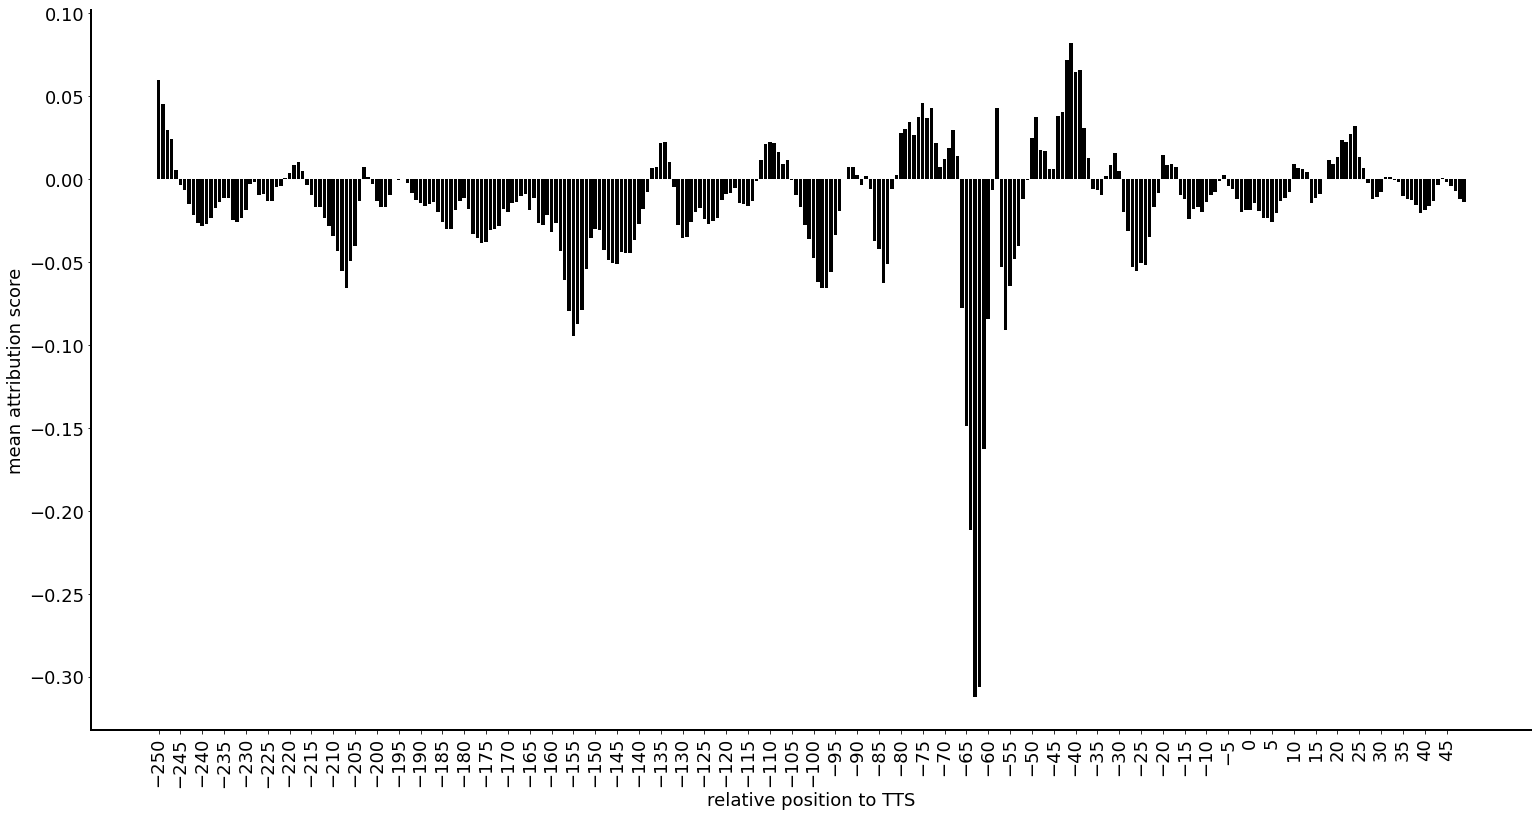

In [ ]:
import matplotlib.font_manager as fm
import matplotlib as mpl
from pylab import cm

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

colors = cm.get_cmap('tab10', 2)

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0, 0, 1, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

attributions, logits = attribution_wrapper(lig, seqs[5])
ax.bar(range(-250, 50), attributions, color=['black'])
plt.xticks(np.arange(-250, 50, 5.0), rotation='vertical')
plt.xlabel("relative position to TTS")
plt.ylabel("mean attribution score")
"""
PRSS22 = encodes a member of the trypsin family of serine proteases. 
          The enzyme is expressed in the airways in a developmentally regulated manner.
TPM = 1.00
peak region = -68 to -58
AP2B_HUMAN.H11MO.0.B = protein functions as both a transcriptional activator and repressor
COE1_HUMAN.H11MO.0.A = Predicted to be involved in positive regulation of transcription by RNA polymerase II. Predicted to act upstream of or within positive regulation of transcription
CTCF_HUMAN.H11MO.0.A = Transcriptional Repressor CTCF, 11 Zinc Finger Transcriptional Repressor
ZN320_HUMAN.H11MO.0.C = encodes a Kruppel-like zinc finger protein. Members of this protein family are involved in activation or repression of transcription
"""

single


'\n\n'

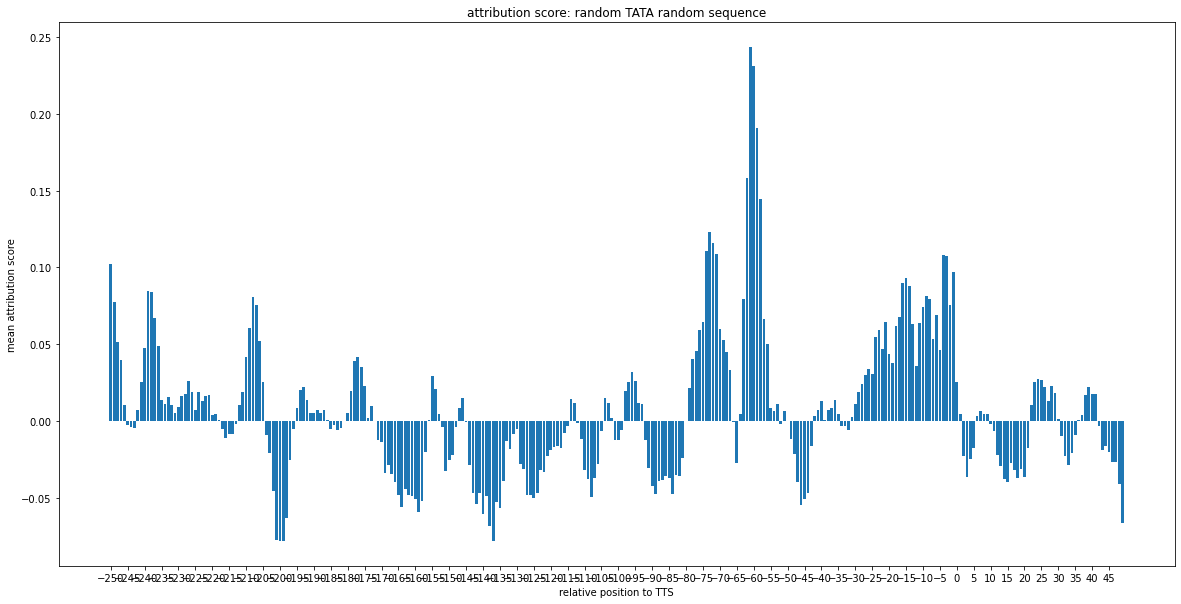

In [ ]:
attributions, logits = attribution_wrapper(lig, seqs[6])
plt.figure(figsize=(20,10))
plt.bar(range(-250, 50), attributions)
plt.title("attribution score: random TATA random sequence")
plt.xticks(np.arange(-250, 50, 5.0))
plt.xlabel("relative position to TTS")
plt.ylabel("mean attribution score")
"""
SLC25A5 = member of the mitochondrial carrier subfamily of solute carrier protein genes. 
          The product of this gene functions as a gated pore that translocates ADP from the 
          cytoplasm into the mitochondrial matrix and ATP from the mitochondrial matrix into the cytoplasm.
TPM = 247.70
peak region = -64 to -57
SUH_HUMAN.H11MO.0.A = transcriptional regulator important in the Notch signaling pathway. 
                      The encoded protein acts as a repressor when not bound to Notch proteins and an 
                      activator when bound to Notch proteins. It is thought to function by recruiting 
                      chromatin remodeling complexes containing histone deacetylase or histone acetylase 
                      proteins to Notch signaling pathway genes.
NR0B1_HUMAN.H11MO.0.D = The encoded protein acts as a dominant-negative regulator of transcription 
                        which is mediated by the retinoic acid receptor.
"""

single


Text(0, 0.5, 'mean attribution score')

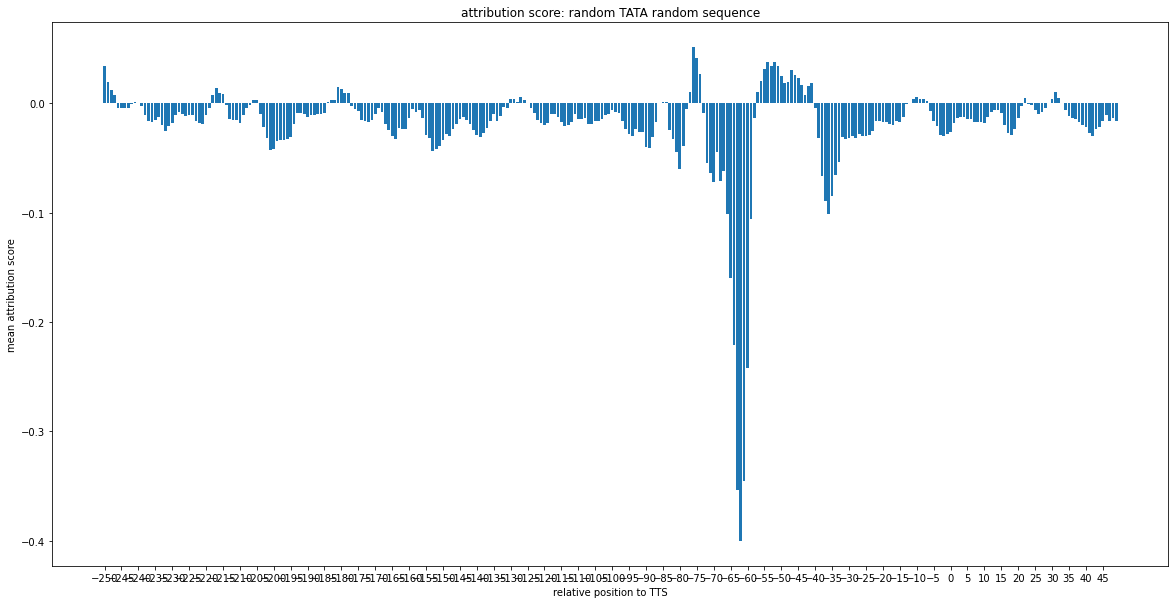

In [ ]:
attributions, logits = attribution_wrapper(lig, seqs[8])
plt.figure(figsize=(20,10))
plt.bar(range(-250, 50), attributions)
plt.title("attribution score: random TATA random sequence")
plt.xticks(np.arange(-250, 50, 5.0))
plt.xlabel("relative position to TTS")
plt.ylabel("mean attribution score")
"""
ACSM3 = Enables butyrate-CoA ligase activity. Predicted to be involved in acyl-CoA metabolic process and fatty acid biosynthetic process. 
TPM = 2.50
peak region = -67 to -59
KAISO_HUMAN.H11MO.0.A = encodes a transcriptional regulator with bimodal DNA-binding specificity, 
                        which binds to methylated CGCG and also to the non-methylated consensus KAISO-binding site TCCTGCNA.
                        It recruits the N-CoR repressor complex to promote histone deacetylation and the formation of 
                        repressive chromatin structures in target gene promoters. It may contribute to the repression 
                        of target genes of the Wnt signaling pathway
"""